In [224]:
# Processamento de Imagens SCC0251 - 2022.1
# Projeto Final

# Nomes: 
  # João Victor Sene Araújo  | nUSP: 11796382
  # Pedro Augusto Ribeiro Gomes | nUSP: 11819125

# Algoritmo para Restauração de Imagens

In [225]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

## Comparação da metologia adotada com outros métodos

### Bibliotecas utilizadas

Dado o tema, o objetivo e a metodologia do projeto, iremos implementar a aplicação comparando com métodos da categoria non-blind deconvolution, isto é, métodos que utilizam de certas estimativas iniciais e/ou parametros já conhecidos para serem executados.

### Funções gerais usadas nos métodos

In [226]:
def paddingKernel(img,kernel):
  """
    Aplica o padding em um filtro(kernel) referente ao tamanho da imagem dada

      Parâmetros:
        img = imagem de referência
        kernel = filtro a ser aplicado o padding

      Retorno: 
        Kernel com padding
  """
  min_img_shape = min(img.shape[0],img.shape[1])
  
  padSize = int(min_img_shape//2 - kernel.shape[0]//2)
  paddedArr = np.pad(kernel, (padSize-1, padSize-1), 'constant',constant_values=(0))
  gaussianFilterPad = np.zeros_like(img).astype(paddedArr.dtype)
  # copy the padded array to the gaussian filter_pad
  gaussianFilterPad[0:paddedArr.shape[0], 0:paddedArr.shape[1]] = paddedArr

  return gaussianFilterPad

def fftConvolve(img,psf):
  """
    Realiza uma convolução no domínio de frequência entre uma imagem e uma psf(point spread function)

      Parâmetros:
        img = imagem que irá passar pelo filtro
        psf = point spread function associada ao borrão de movimento na imagem

      Retorno: 
        Resultado da convolução entre as duas matrizes
  """
  otf = np.fft.fft2(psf)

  F = np.fft.fft2(img)
  F = np.multiply(F,otf)

  return np.fft.fftshift(abs(np.fft.ifft2(F)))

def normalize(img):
  """
    Normaliza a imagem dada (coloca os valores dos pixels entre 0 e 255)

      Parâmetros:
        img = matriz da imagem que vai ser normalizada

      Retorno: 
        imagem normalizada
  """
  imgN = img.copy()
  imgN = (imgN - np.min(imgN[:])) / (np.max(imgN[:]) - np.min(imgN[:]))
  imgN = (imgN*255).astype(np.uint8)

  return imgN

### Funções usadas no método de blind deconvolution

In [227]:

def richardson_lucy_blind(img, psf, num_iter=50,debug=False):
  """
    Realiza o algorítimo de restauração Richardson-Lucy para uma determinada imagem
    utilizando uma psf como chute inicial para deconvoluir a imagem. Sendo u a imagem
    que será estimada, P a psf que também será estimada, d a imagem, P* a psf flipada
    e @ indicando convolução entre os termos:

    u_(t+1) = u_(t) * ( ( d / ( u_(t) @ P_(t) ) ) @ P_(t)* )

    P_(t+1) = P_(t) * ( ( d / ( u_(t+1) @ P_(t) ) ) @ u_(t+1)* )

    Esse processo será realizado 'maxIteration' vezes, com o objetivo de aprimorar
    a estimação (convergir para a imagem original)

      Parâmetros:
        img = imagem que irá passar pelo filtro
        psf = chute inicial para point spread function associada ao borrão de 
        movimento na imagem
        num_iter = número máximo de iteração realizadas pelo algoritmo

      Retorno: 
        Imagem estimada
  """
  u = np.full(img.shape, 0.1, dtype='float')
  
  eps = 1e-12

  for i in range(num_iter):
    psf_f = np.flip(psf)

    u_blur = fftConvolve(u,psf)+eps
    relative_blur = np.divide(img,u_blur)
    u *= fftConvolve(relative_blur,psf_f)

    u_f = np.flip(u)
    u_blur = fftConvolve(u, psf)+eps
    relative_blur = img / u_blur
    psf *= fftConvolve(relative_blur, u_f)

    if(debug):
      plt.figure(figsize=(16,9))
      plt.subplot(121)
      plt.imshow(u, cmap="gray", vmin=0, vmax=255); plt.title("image")
      plt.subplot(122)
      plt.imshow(normalize(psf), cmap="gray", vmin=0, vmax=255); plt.title("psf")

  return u,psf


### Funções usadas nos métodos non-blind **deconvolution**

In [228]:

# Filtro gaussiano mostrado e utilizado pelo professor Moacir
def gaussian_filter(k=5, sigma=1.0):
  """
    Cria um filtro(kernel) Gaussiano para um dado k e sigma

      Parâmetros:
        k = tamanho do filtro de degradação (k x k)
        sigma = desvio padrão para a degradação gaussiana (desfoque)

      Retorno: 
        Filtro Gaussiano kxk
  """
  arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
  x, y = np.meshgrid(arx, arx)
  filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))

  return filt / np.sum(filt)
  

def gaussianBlur(img,filter):
  """
    Aplica o filtro de borrão Gaussiano no domínio de frequência na imagem dada

      Parâmetros:
        img = imagem que irá passar pelo filtro 
        filter = filtro gaussiano

      Retorno: 
        Imagem degradada(borrada)
  """
  filter_pad = paddingKernel(img,filter)

  F = np.fft.fft2(img)
  H = np.fft.fft2(filter_pad)

  G = np.multiply(F,H)

  g = np.fft.ifftshift(np.fft.ifft2(G).real)

  return g;


def clsq(img,gamma,filter):
  """
    Realiza o CLSQ (Constrained Least Squares Filter) na imagem dada, restaurando-a
    Nesse processo, a imagem f a ser estimada será calculada pela seguinte equação:

    F = [ H* / ( |H|^2 + gamma * |P|^2 )] * G

    Onde: F = imagem no domínio de frequência, H = filtro no domínio de frequência,
    H* = conjugado de H, P = operador Laplaciano no domínio de frequência,
    G = imagem no domínio de frequência

      Parâmetros:
        img = imagem borrada que irá ser restaurada
        gamma = controla a influência da regularização
        filter = filtro psf que foi aplicado na img

      Retorno: 
        Imagem restaurada
  """

  p = np.array([[0,-1,0],
               [-1,4,-1],
               [0,-1,0]])

  p_pad = paddingKernel(img,p)

  P = np.fft.fft2(p_pad)
  G = np.fft.fft2(img)
  H = np.fft.fft2(filter)

  F = np.multiply(np.divide(np.conjugate(H),(abs(H)**2 + np.multiply(abs(P)**2,gamma))),G)

  f = np.fft.ifftshift(np.fft.ifft2(F).real)

  return f

def RMSE(image1,image2):
  """
    Realiza um calculo que compara duas imagens(matrizes), retornando um valor
    que quantifica o quão diferente uma imagem é da outra (quanto maior, mais
    diferente uma é da outra)

      Parâmetros:
        image1 = matriz da primeira imagem a se comparada
        image2 = matriz da segunda imagem a se comparada

      Retorno: 
        Valor escalar que mostra o quão diferente uma imagem é da outra
  """
  return (np.sum((image1-image2)**2) * (1/(len(image1)*len(image1[0]))))**(1/2)

def RLDeconvolution(img,psf,maxIterations):
  """
    Realiza o algorítimo de restauração Richardson-Lucy para uma determinada imagem
    Sendo u a imagem que será estimada, P a psf, d a imagem, P* a psf flipada e
    @ indicando convolução entre os termos:

    u_(t+1) = u_(t) * ( ( d / ( u_(t) @ P ) ) @ P* )

    Esse processo será realizado 'maxIteration' vezes, com o objetivo de aprimorar
    a estimação (convergir para a imagem original)

      Parâmetros:
        img = imagem que irá passar pelo filtro
        psf = point spread function associada ao borrão de movimento na imagem
        maxIterations = número máximo de iteração realizadas pelo algoritmo

      Retorno: 
        Imagem estimada
  """
  u = np.full(shape = img.shape, fill_value = 0.5, dtype = "float64")
  psf_f = np.flip(psf)

  #Evita que a haja divisões apenas por zeros
  eps = 1e-12

  for i in range(maxIterations):
    u = np.multiply(u, fftConvolve(np.divide(img,fftConvolve(u,psf)+eps),psf_f))
  
  return u


###Abertura da imagem em grayscale

Text(0.5, 1.0, 'Original')

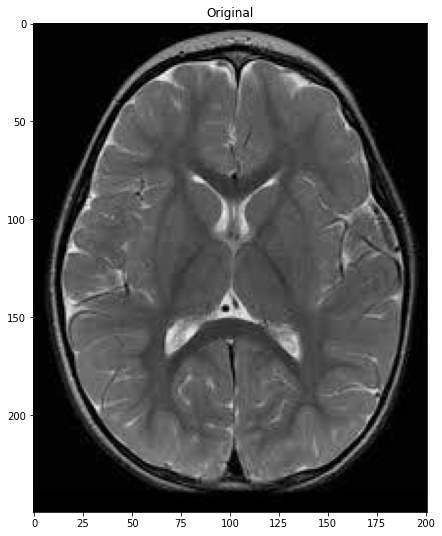

In [229]:
imageName = "4.jpg"

img = imageio.imread(imageName)

plt.figure(figsize=(12,9))
plt.subplot(111)
plt.imshow(img, cmap="gray", vmin=0, vmax=255); plt.title("Original")

### Criação do filtro gaussiano e aplicação do mesmo na imagem original, criando, assim, a imagem borrada

Text(0.5, 1.0, 'Blur')

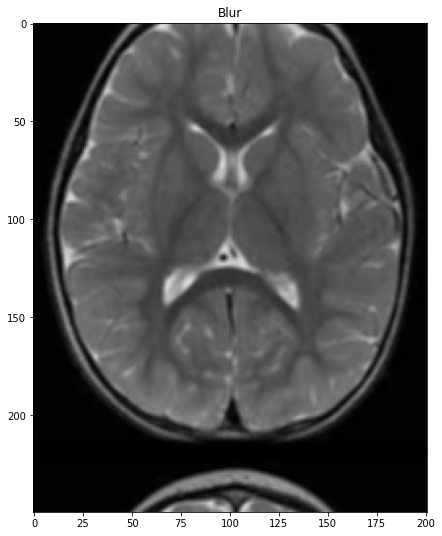

In [230]:

k = 3
sigma = 2.0

filter = gaussian_filter(k,sigma)
img_blur = gaussianBlur(img,filter)

filter = paddingKernel(img_blur,filter)

plt.figure(figsize=(12,9))
plt.subplot(111)
plt.imshow(img_blur, cmap="gray", vmin=0, vmax=255); plt.title("Blur")

### Método CLSQ utilizando parametros estipulados e conhecidos

Considerando a relação:

$g = h * f + n$

, onde $g$ é a imagem degradada(registrada pelo dispositivo), $h$ é a função de degradação(filtro de blur), $f$ a imagem original(ideal) , $n$ o ruído e $*$ uma operação de convolução.

Considerando a seguinte restrição:

$||g-hf||^2 + ||n||^2$

, conseguimos chegar em uma solução direta (mas não perfeita) que consiga restaurar a imagem, isto é, encontrar o $f$.

A solução, considerando o domínio de frequência, é:

$F = {\dfrac{H'}{|H|^2 + γ|P|^2}} G$

, onde $F$, $H$ e $G$ são, respectivamente, as matrizes de $f$, $h$ e $g$ no domínio de frequência, $γ$ (gamma) representa um parametro de regularização, $H'$ é a matriz H flipada e $P$ é o operador Laplaciano no domínio de frequência.

In [231]:

gamma = 0.1

f_clsq = clsq(img_blur,gamma,filter)
f_clsq = np.clip(f_clsq.astype(int),np.min(img_blur[:]),np.max(img_blur[:]))
f_clsq = normalize(f_clsq)

### Método RL utilizando a psf que foi convoluida com a imagem original

O método Richardson-Lucy tem como objetivo encontrar a imagem ideal(sem borrões e noises) através de um processo iterativo na qual a imagem converge para a solução de máxima probabilidade(maximun likelihood solution). O processo consiste em:

$u_{t+1} = u_t ({\dfrac{d}{u_t * P}}*P')$

, onde $u_t$ é a imagem que está gradualmente convergindo(sendo $u_0 = g = $ imagem borrada), $d$ é a $g=$ imagem borrada, $P$ a PSF(point spread function $=h=$ filtro usado na convolução) e $P'$ é a matriz $P$ flipada.

In [232]:

maxIterations = 4

f_RL = RLDeconvolution(img,filter,maxIterations)
f_RL = np.clip(f_RL.astype(int),0,255)
f_RL = normalize(f_RL)

### Método RL utilizando uma psf 5x5 com todos os valores iguais, sendo que a soma destes valores é igual a 1 (blind deconvolution)

Text(0.5, 1.0, 'Restored PSF')

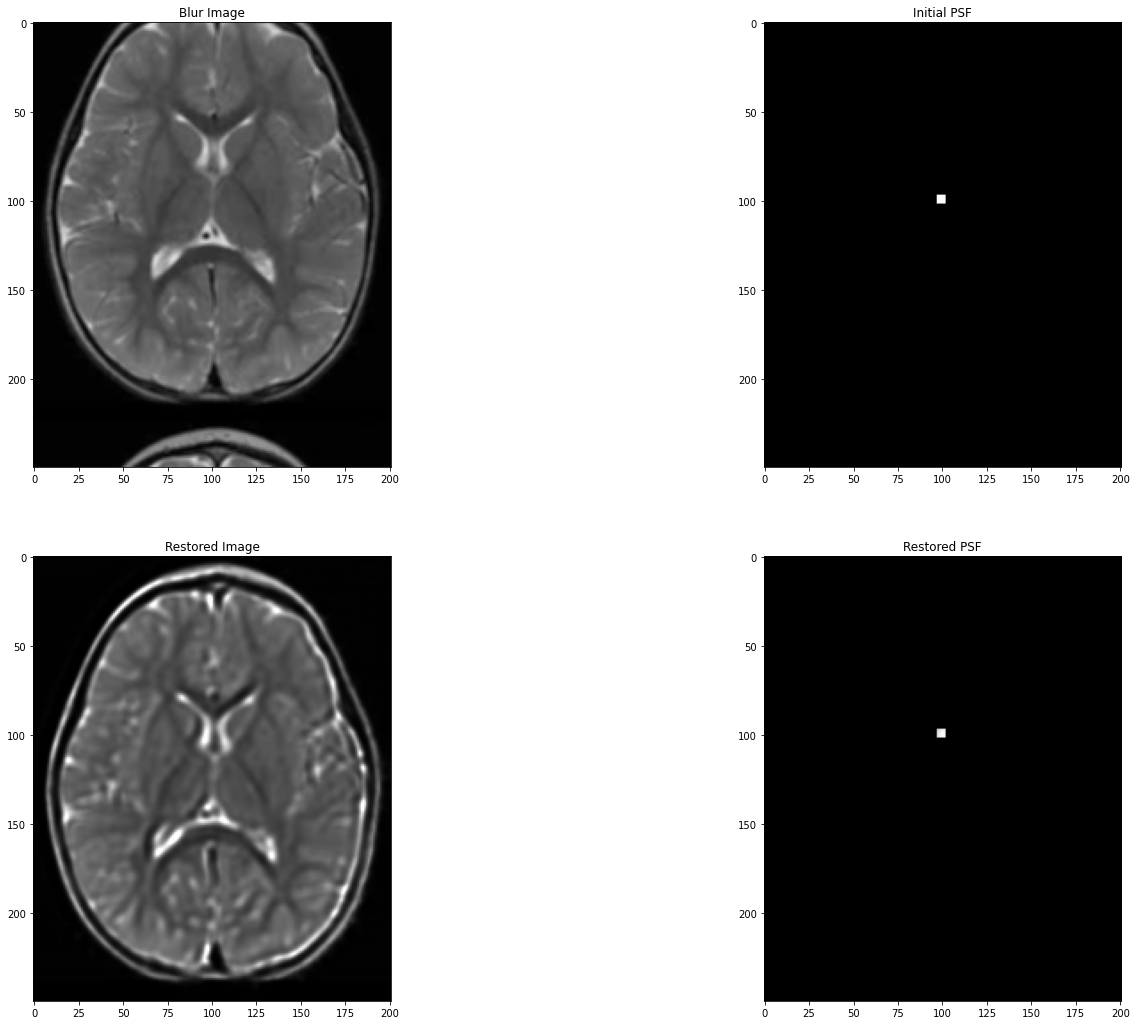

In [233]:

maxIterations = 4

psf_init = np.ones((5,5))/25
psf_init = paddingKernel(img_blur,psf_init)

f_blind,psf_restored = richardson_lucy_blind(img_blur, psf_init.copy(), num_iter=maxIterations)
f_blind = np.clip(f_blind.astype(int),0,255)
f_blind = normalize(f_blind)

plt.figure(figsize=(24,18))
plt.subplot(221)
plt.imshow(img_blur, cmap="gray", vmin=0, vmax=255); plt.title("Blur Image")
plt.subplot(222)
plt.imshow(normalize(psf_init), cmap="gray", vmin=0, vmax=255); plt.title("Initial PSF")
plt.subplot(223)
plt.imshow(f_blind, cmap="gray", vmin=0, vmax=255); plt.title("Restored Image")
plt.subplot(224)
plt.imshow(normalize(psf_restored), cmap="gray", vmin=0, vmax=255); plt.title("Restored PSF")

### Plot das imagens para uma comparação visual

Text(0.5, 1.0, 'RL blind')

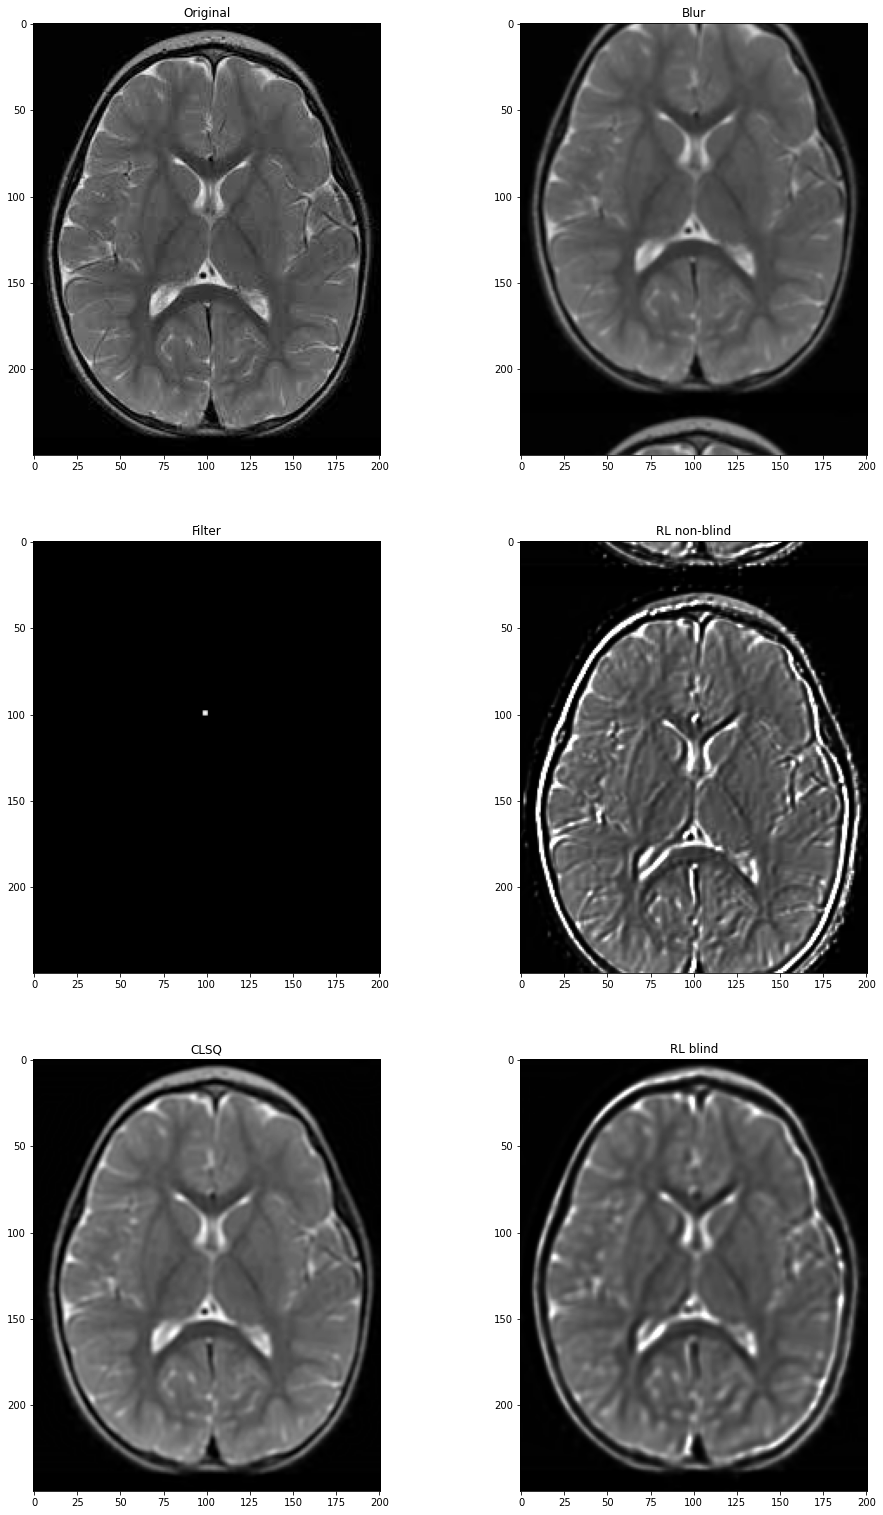

In [234]:

plt.figure(figsize=(16,27))
plt.subplot(321)
plt.imshow(img, cmap="gray", vmin=0, vmax=255); plt.title("Original")
plt.subplot(322)
plt.imshow(img_blur, cmap="gray", vmin=0, vmax=255); plt.title("Blur")
plt.subplot(323)
plt.imshow(normalize(filter), cmap="gray", vmin=0, vmax=255); plt.title("Filter")
plt.subplot(324)
plt.imshow(f_RL, cmap="gray", vmin=0, vmax=255); plt.title("RL non-blind")
plt.subplot(325)
plt.imshow(f_clsq, cmap="gray", vmin=0, vmax=255); plt.title("CLSQ")
plt.subplot(326)
plt.imshow(f_blind, cmap="gray", vmin=0, vmax=255); plt.title("RL blind")

### Conclusão

Como é possível observar, os resultados não foram visivelmente e suficientemente satisfatórios, ocorrendo certas distorções nos métodos iterativos(como a "criação de bordas fantasmas", na qual ocorre um enrrugamento de certas áreas da imagem) e resultados pouco eficazes.

## Aplicação do método nas 10 imagens escolhidas para teste

### Aplicação do blur

Nesta etapa, aplicamos um filtro de blur aleatório sobre as imagens, de modo que conseguimos gerar imagens borradas a partir de diferentes fitros. Assim, utilizamos a biblioteca PIL para auxiliar na conversão das imagens

In [235]:
from PIL import Image
import random

images_names = ["1.jpg",
                "2.jpg",
                "3.jpg",
                "4.jpg",
                "5.jpg",
                "6.jpg",
                "7.jpg",
                "8.jpg",
                "9.jpg",
                "10.jpg"]

for image_name in images_names:
  Image.open(image_name).convert('L').save(image_name)
  img = imageio.imread(image_name)

  n=10;
  s = random.randint(3, 9)

  psf = gaussian_filter(k=n, sigma=s)
  psf = paddingKernel(img,psf)

  img_blur = fftConvolve(img,psf)

  imageio.imwrite("blur/"+image_name, img_blur)

### Aplicação do algoritmo em cada imagem borrada gerada no processo anterior

(630, 630)
630
(630, 630)
630
(225, 225)
225
(250, 201)
201
(225, 225)
225
(192, 192)
192
(417, 428)
417
(251, 201)
201
(201, 173)
173
(201, 173)
173


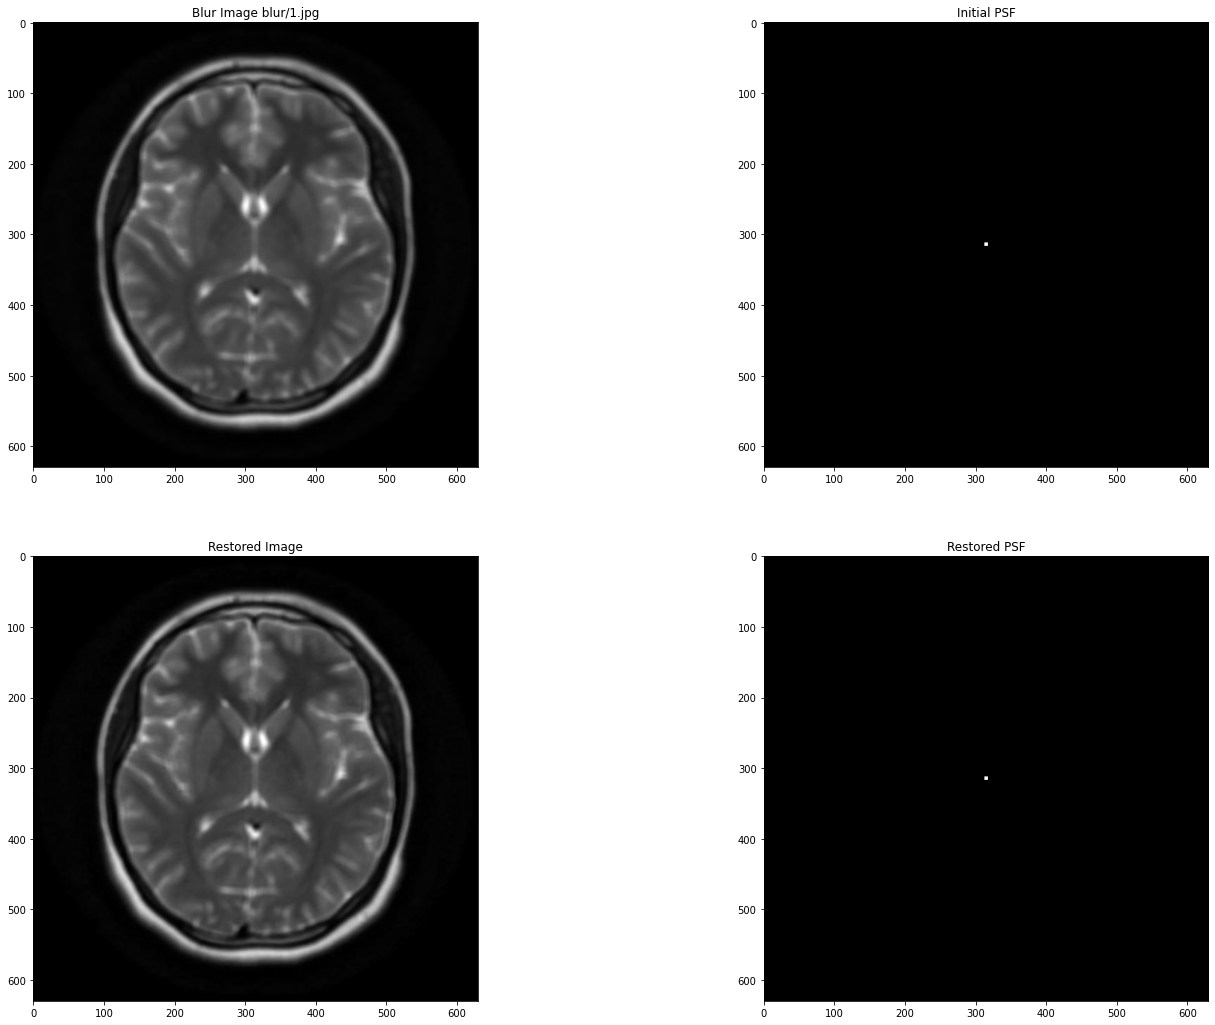

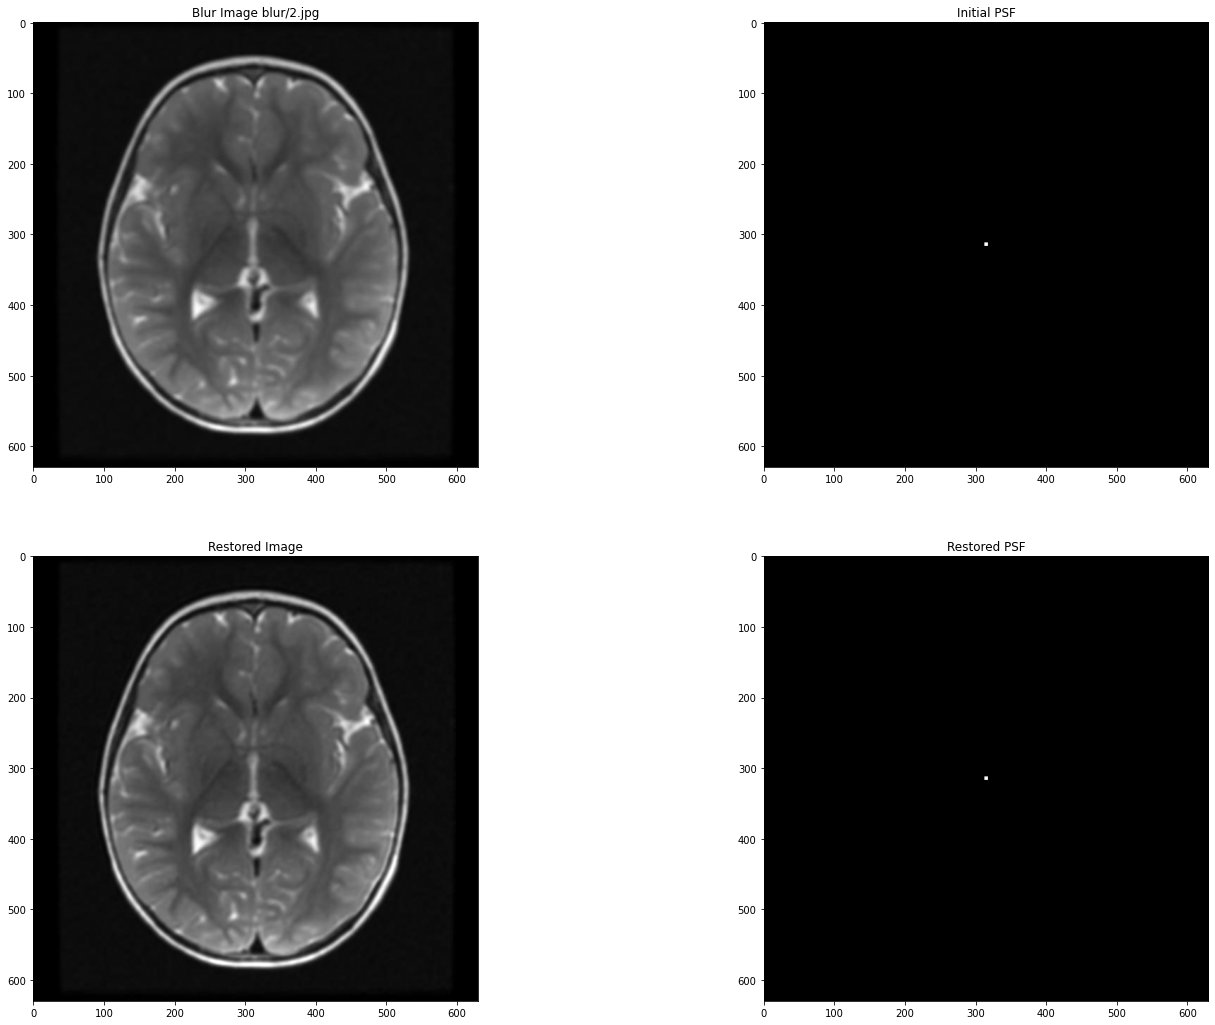

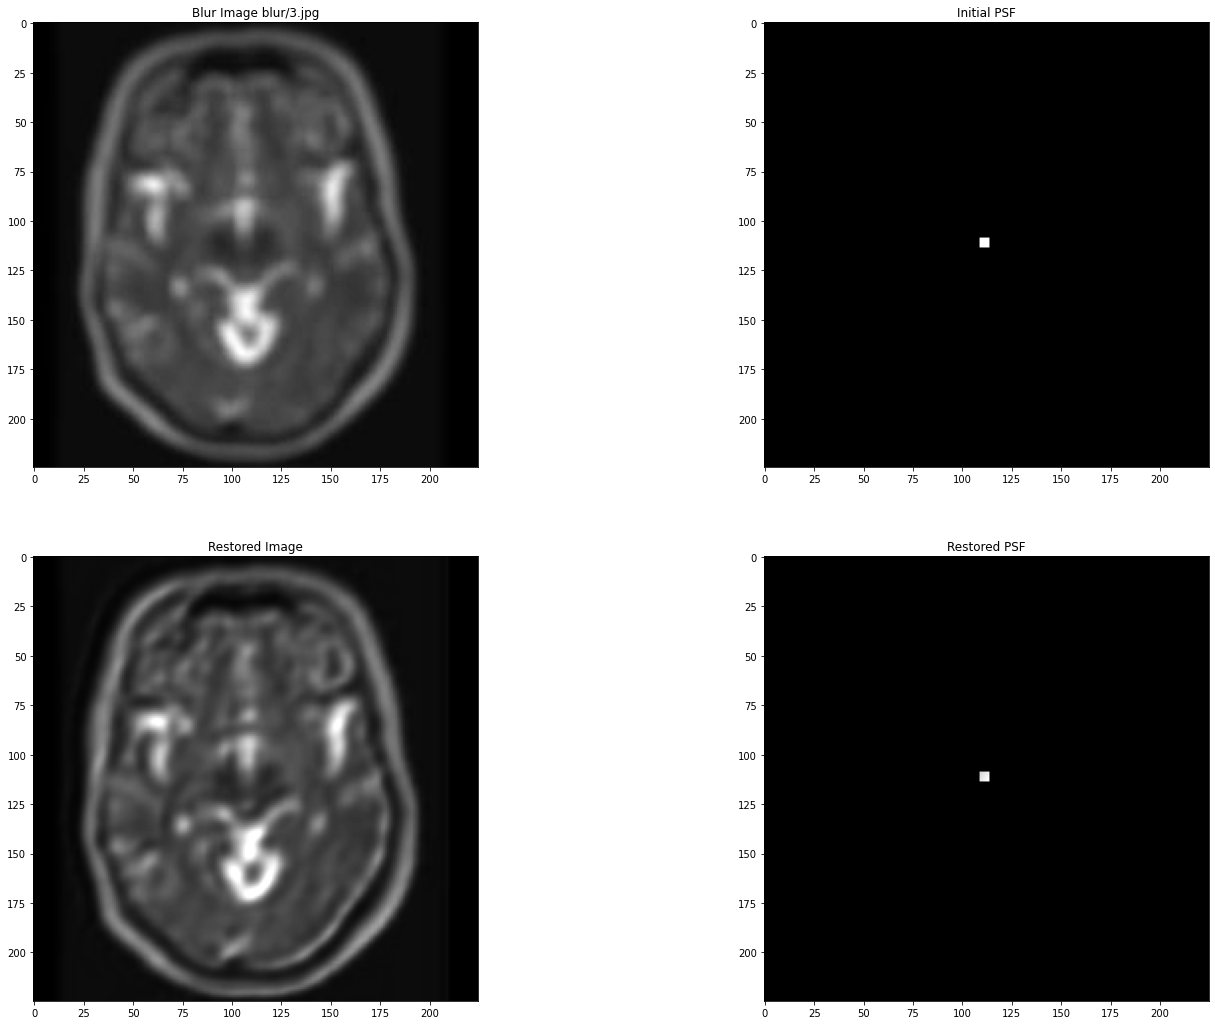

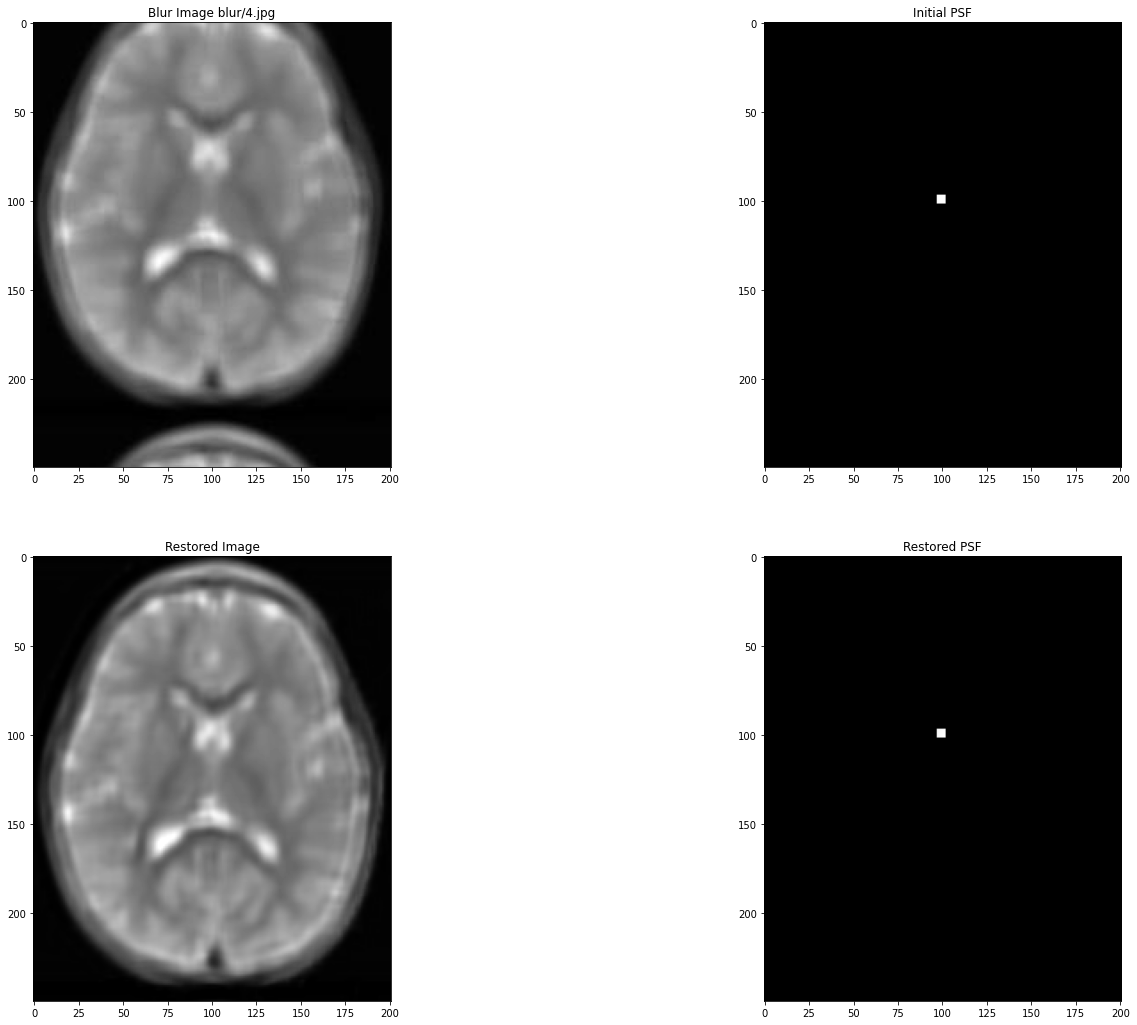

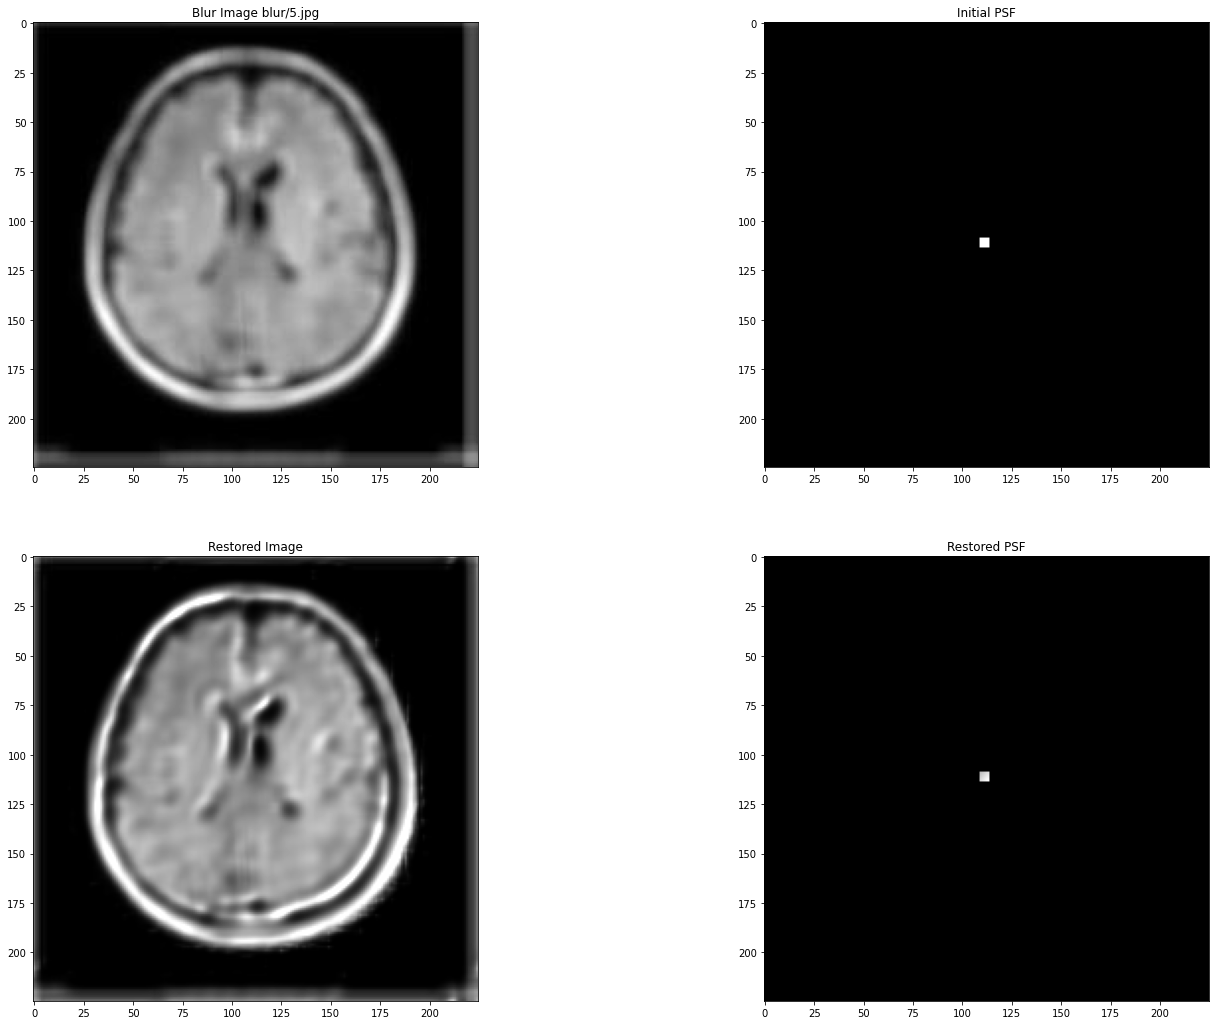

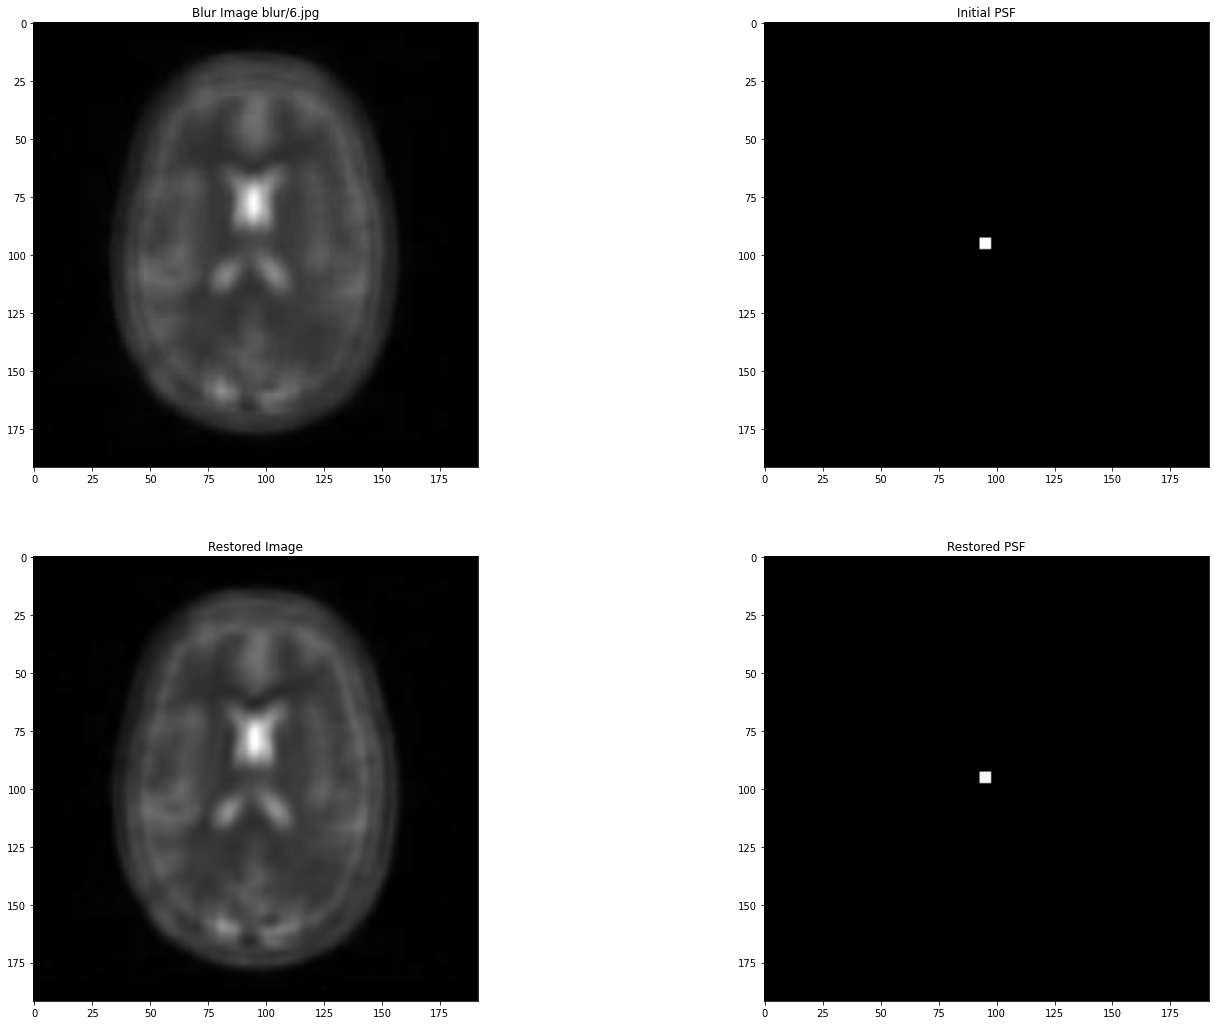

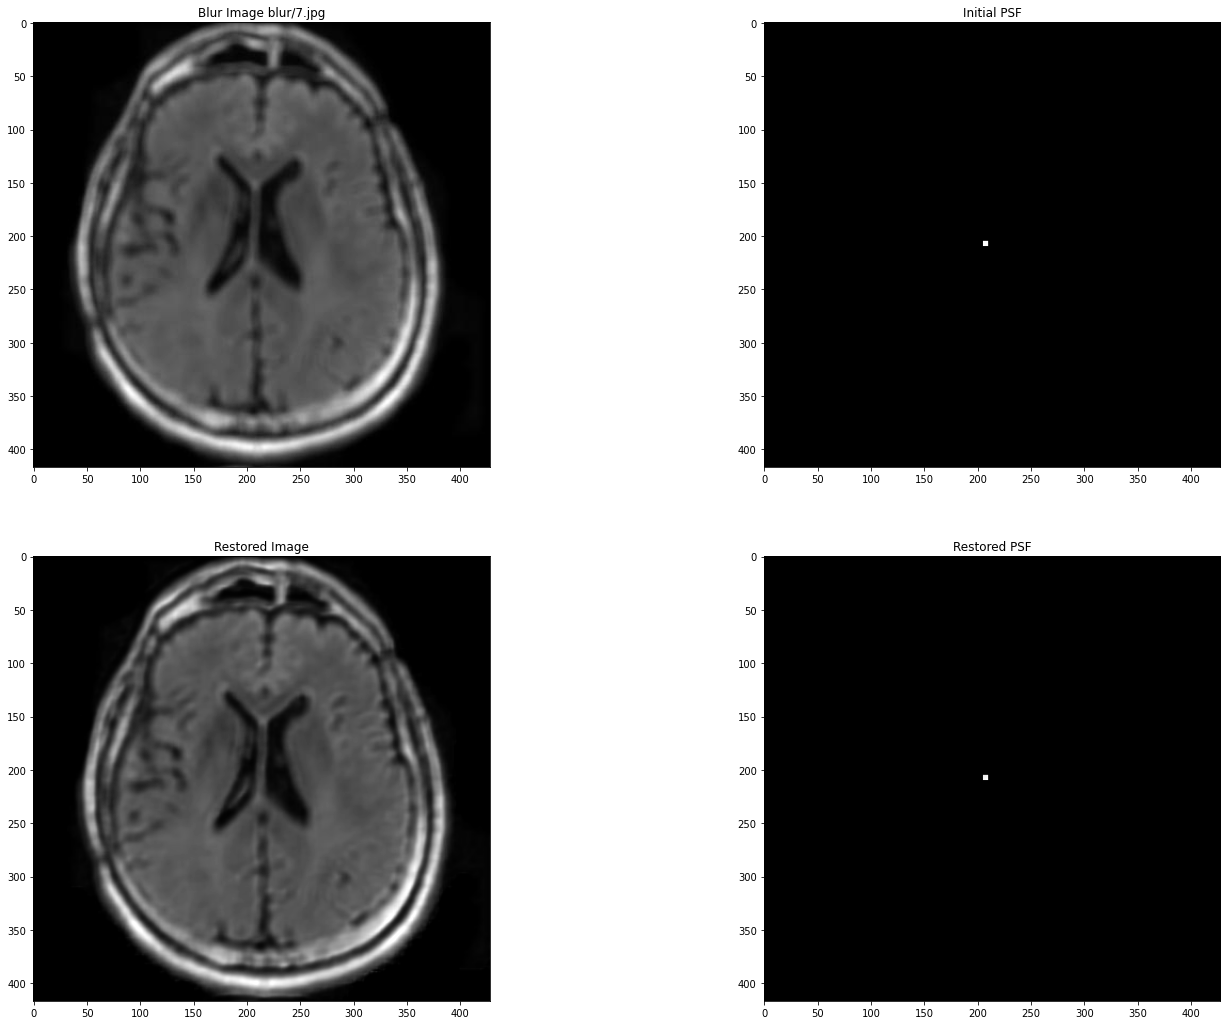

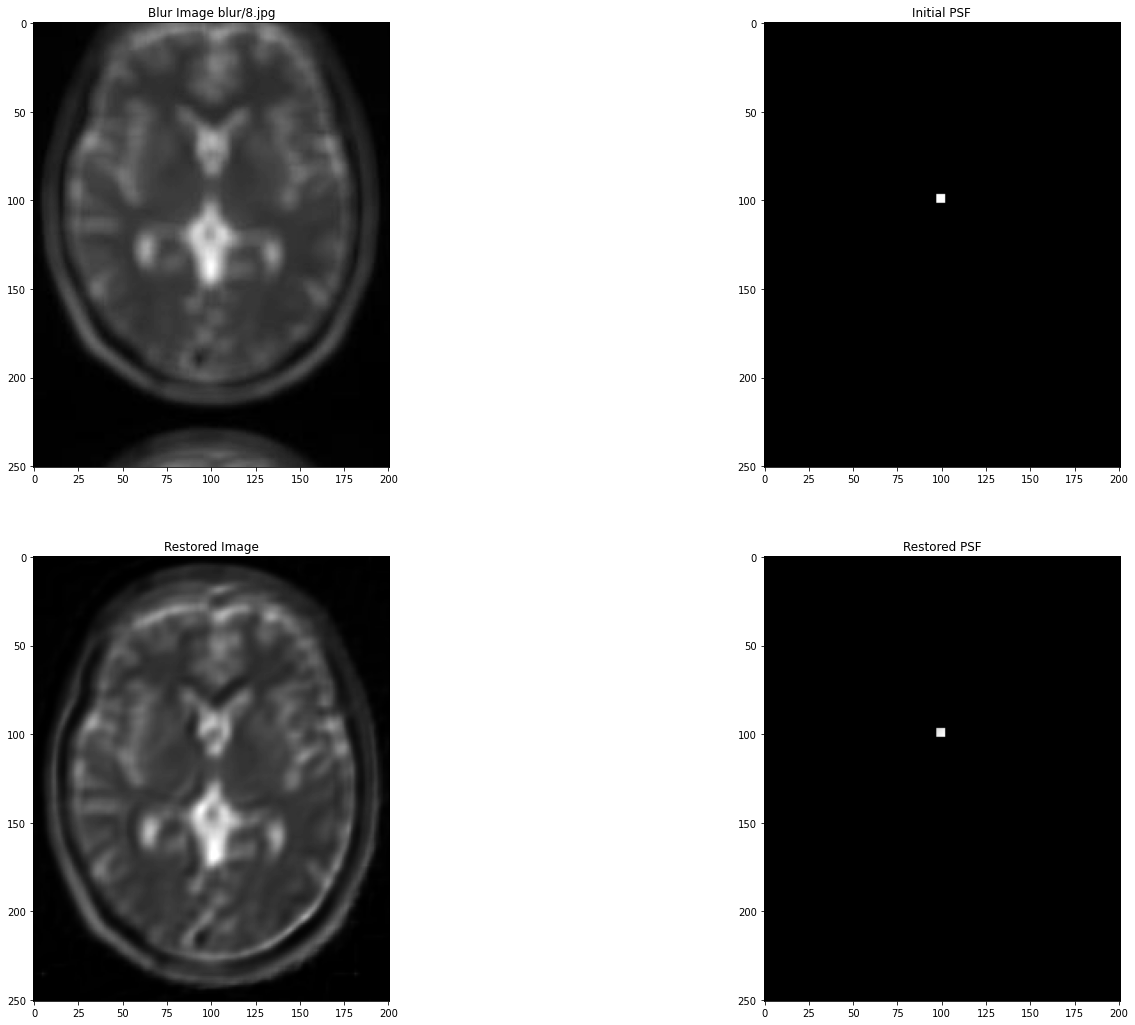

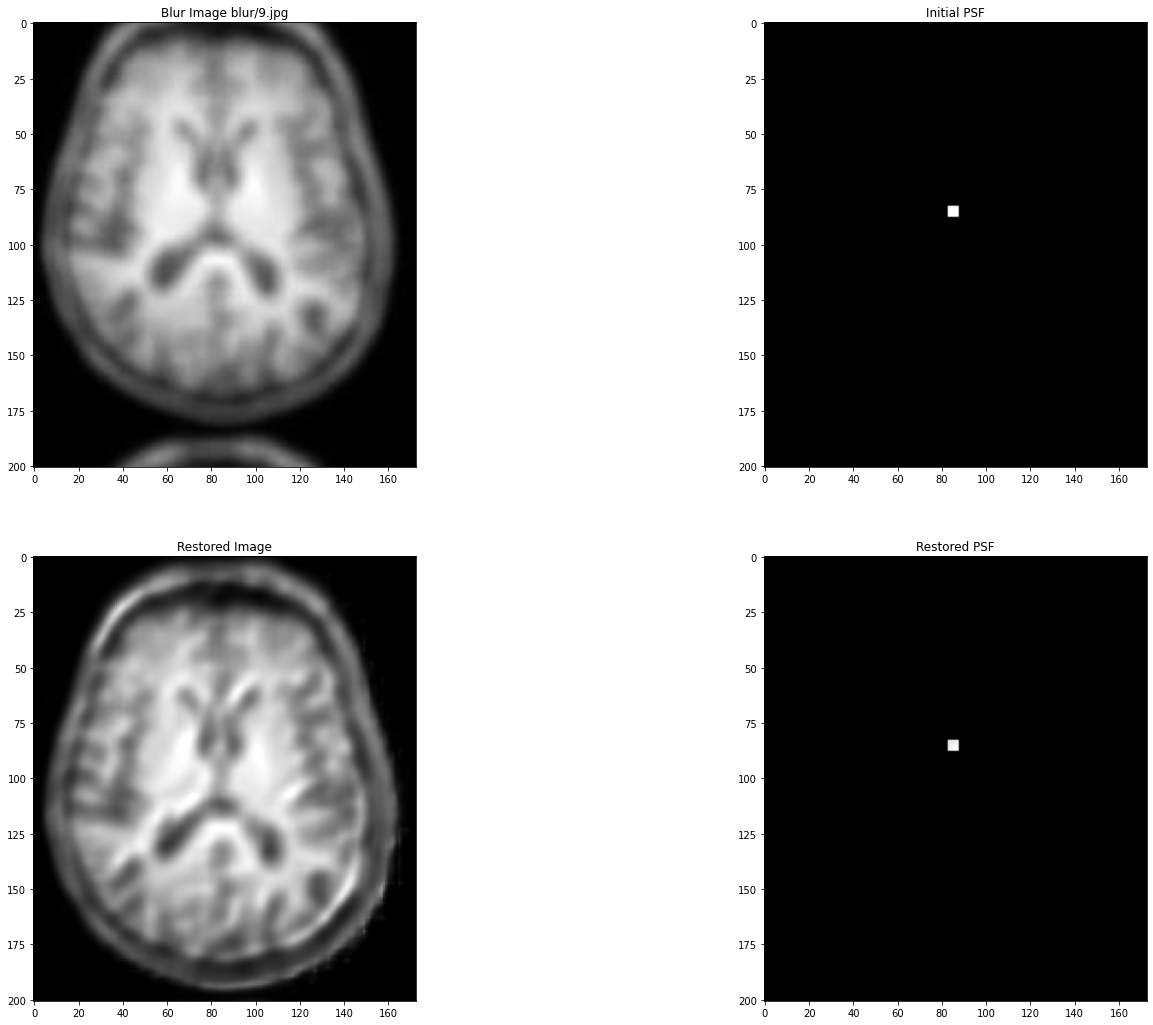

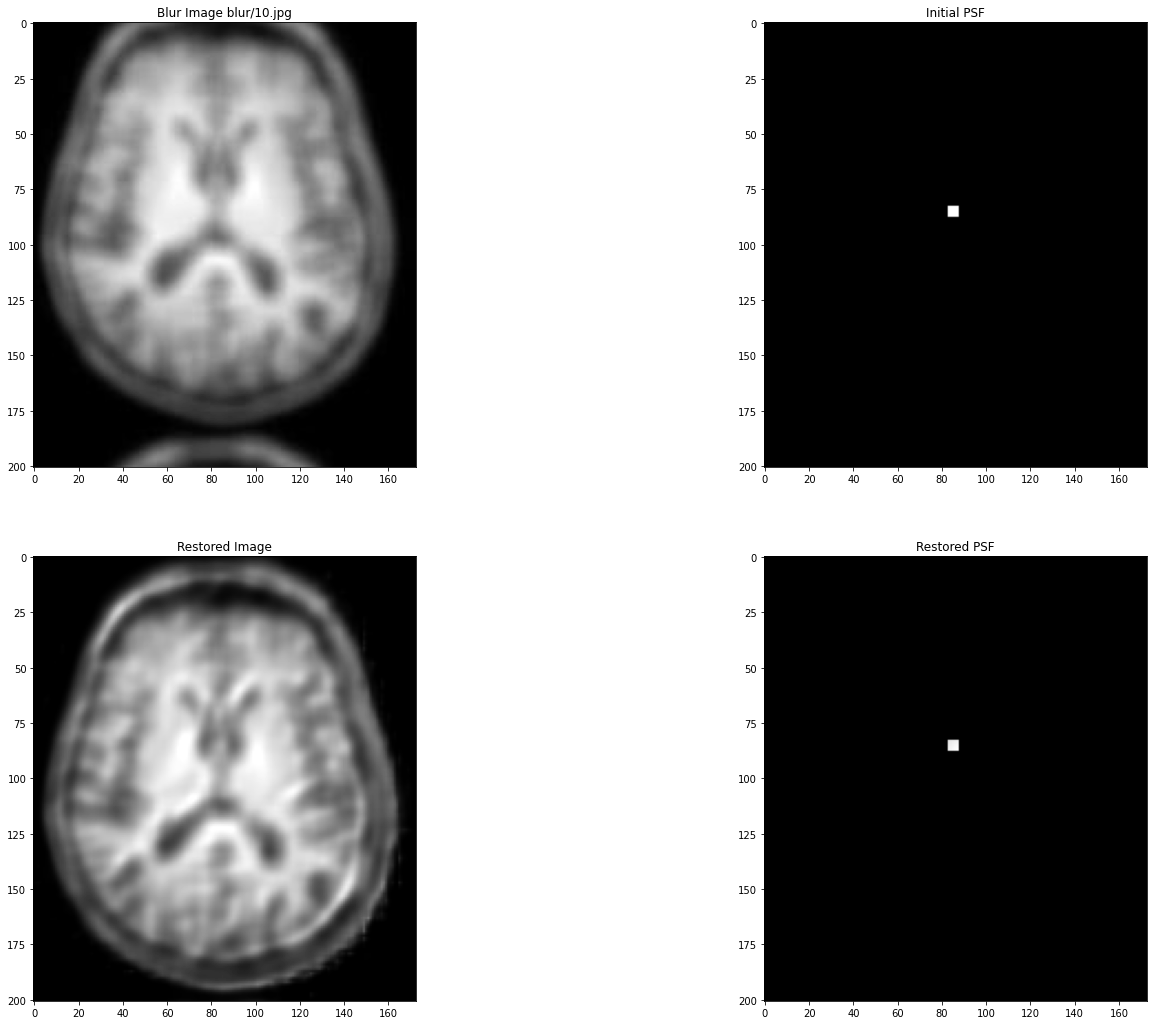

In [223]:
images_names = ["blur/1.jpg",
                "blur/2.jpg",
                "blur/3.jpg",
                "blur/4.jpg",
                "blur/5.jpg",
                "blur/6.jpg",
                "blur/7.jpg",
                "blur/8.jpg",
                "blur/9.jpg",
                "blur/10.jpg"]

maxIterations = 4

for image_name in images_names:
  img_blur = imageio.imread(image_name)

  psf_init = np.ones((5,5))/25
  psf_init = paddingKernel(img_blur,psf_init)
  
  f_blind,psf_restored = richardson_lucy_blind(img_blur, psf_init.copy(), num_iter=maxIterations)
  f_blind = np.clip(f_blind.astype(int),0,255)
  f_blind = normalize(f_blind)

  plt.figure(figsize=(24,18))
  plt.subplot(221)
  plt.imshow(img_blur, cmap="gray", vmin=0, vmax=255); plt.title("Blur Image "+image_name)
  plt.subplot(222)
  plt.imshow(normalize(psf_init), cmap="gray", vmin=0, vmax=255); plt.title("Initial PSF")
  plt.subplot(223)
  plt.imshow(f_blind, cmap="gray", vmin=0, vmax=255); plt.title("Restored Image")
  plt.subplot(224)
  plt.imshow(normalize(psf_restored), cmap="gray", vmin=0, vmax=255); plt.title("Restored PSF")

### Conclusão

Como é possível observar, as imagens não obtiveram um resultado visual muito satisfatório. Entretando, dá para notar certas diferenças entre a imagem borrada e a imagem restaurada, como um certo destaque a partes que apresentam bordas e curvas, o que faz com que o processo crie bordas fantasmas.